In [111]:
import numpy as np
import casadi as ca
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Input
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

In [112]:
# !pip install casadi

## System Description


In [113]:
class CarSuspension:
    def __init__(self, x0, dt=0.001, T_f=10):
        # System parameters from the paper (page 4)
        self.m_us = 40     # Unsprung mass (kg)
        self.m_s = 290     # Body mass (kg)
        self.m_f = 15      # Seat frame mass (kg)
        self.m_c = 1       # Cushion mass (kg)
        
        self.k_t = 190000  # Linear tire stiffness (N/m)
        self.k_tnl = 1.5 * self.k_t  # Nonlinear tire stiffness (N/m²)
        
        self.k_s = 23500   # Linear spring stiffness (N/m)
        self.k_snl = 100 * self.k_s  # Nonlinear spring stiffness (N/m³)
        self.k_f = 31000   # Seat frame stiffness (N/m)  
        self.k_c = 18000  # Cushion stiffness (N/m)

        
        self.c_s = 700     # Suspension damper (N.s/m)
        self.c_f = 830     # Seat frame damper (N.s/m)
        self.c_c = 200     # Cushion damper (N.s/m)
        
        self.g = 9.81      # Gravitational acceleration (m/s²)
        
        # Time parameters
        self.dt = dt       # Time step (s)
        self.T_f = T_f     # Final time
        self.t = 0.0       # Current time
        self.t_vec = np.linspace(0, self.T_f, int(self.T_f/self.dt))  # Time vector
                                 
        # Initial conditions
        self.x0 = np.array(x0, dtype=float).reshape(-1,1)
        self.state_dim = len(x0)  # 8 state variables
        self.input_dim = 1        # Control force (u)
        self.output_dim = 4       # Outputs (displacements)
        
    def reset(self):
        self.x = self.x0
        self.t = 0.0
        
    def dynamics(self, x, u):
        # Extract state variables
        x_us, x_s, x_f, x_c, dx_us, dx_s, dx_f, dx_c = x.flatten()
        
        # Nonlinear equations (page 4 of the paper)
        ddx_us = (
            -self.k_t * (x_us - 0)              # Road displacement (x_r = 0)
            + self.k_s * (x_s - x_us) 
            + self.c_s * (dx_s - dx_us) 
            + self.k_tnl * (x_us - 0)**2 
            - self.k_snl * (x_s - x_us)**3
        ) / self.m_us
        
        ddx_s = (
            -self.k_s * (x_s - x_us) 
            - self.c_s * (dx_s - dx_us) 
            - self.k_snl * (x_s - x_us)**3 
            + self.k_f * (x_f - x_s) 
            + self.c_f * (dx_f - dx_s)
        ) / self.m_s
        
        ddx_f = (
            -self.k_f * (x_f - x_s) 
            - self.c_f * (dx_f - dx_s) 
            + self.k_c * (x_c - x_f) 
            + self.c_c * (dx_c - dx_f)
        ) / self.m_f
        
        ddx_c = (
            -self.k_c * (x_c - x_f) 
            - self.c_c * (dx_c - dx_f) 
            + u  # Control force applied to the cushion
        ) / self.m_c
        
        return np.array([
            dx_us, dx_s, dx_f, dx_c, 
            ddx_us, ddx_s, ddx_f, ddx_c
        ]).reshape(-1,1)
        
    def dynamics_ca(self, x, u):
        # Casadi version for optimization
        x_us, x_s, x_f, x_c, dx_us, dx_s, dx_f, dx_c = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]
        
        ddx_us = (
            -self.k_t * x_us 
            + self.k_s * (x_s - x_us) 
            + self.c_s * (dx_s - dx_us) 
            + self.k_tnl * x_us**2 
            - self.k_snl * (x_s - x_us)**3
        ) / self.m_us
        
        ddx_s = (
            -self.k_s * (x_s - x_us) 
            - self.c_s * (dx_s - dx_us) 
            - self.k_snl * (x_s - x_us)**3 
            + self.k_f * (x_f - x_s) 
            + self.c_f * (dx_f - dx_s)
        ) / self.m_s
        
        ddx_f = (
            -self.k_f * (x_f - x_s) 
            - self.c_f * (dx_f - dx_s) 
            + self.k_c * (x_c - x_f) 
            + self.c_c * (dx_c - dx_f)
        ) / self.m_f
        
        ddx_c = (
            -self.k_c * (x_c - x_f) 
            - self.c_c * (dx_c - dx_f) 
            + u
        ) / self.m_c
        
        return ca.vertcat(dx_us, dx_s, dx_f, dx_c, ddx_us, ddx_s, ddx_f, ddx_c)
        
    def step(self, u, ca_flag=False):
        # Fourth-order Runge-Kutta method
        if ca_flag:
            k1 = self.dynamics_ca(self.x, u)
            k2 = self.dynamics_ca(self.x + 0.5*self.dt*k1, u)
            k3 = self.dynamics_ca(self.x + 0.5*self.dt*k2, u)
            k4 = self.dynamics_ca(self.x + self.dt*k3, u)
            self.x += (self.dt/6) * (k1 + 2*k2 + 2*k3 + k4)
        else:
            k1 = self.dynamics(self.x, u)
            k2 = self.dynamics(self.x + 0.5*self.dt*k1, u)
            k3 = self.dynamics(self.x + 0.5*self.dt*k2, u)
            k4 = self.dynamics(self.x + self.dt*k3, u)
            self.x += (self.dt/6) * (k1 + 2*k2 + 2*k3 + k4)
        
        self.t += self.dt
        return self.x, self.x[:4]  # Output displacements


## Plot Functions

In [114]:
def plots_state(plant, results):
    time = results["time_hist"]
    state = results["state_hist"]
    state = np.squeeze(state)
    plt.figure(figsize=(12, 8))
    
    # Displacements
    plt.subplot(2, 2, 1)
    plt.plot(time, state[:,0], label='Unsprung Mass (Wheel)')
    plt.plot(time, state[:,1], label='Sprung Mass (Body)')
    plt.plot(time, state[:,2], label='Seat Frame')
    plt.plot(time, state[:,3], label='Seat Cushion')
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (m)')
    plt.title('Displacements')
    plt.legend()
    plt.grid(True)
    
    # Velocities
    plt.subplot(2, 2, 2)
    plt.plot(time, state[:,4], label='Wheel Velocity')
    plt.plot(time, state[:,5], label='Body Velocity')
    plt.plot(time, state[:,6], label='Frame Velocity')
    plt.plot(time, state[:,7], label='Cushion Velocity')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.title('Velocities')
    plt.legend()
    plt.grid(True)
    
    # Accelerations (using velocity derivative)
    plt.subplot(2, 2, 3)

    if len(time) >= 2:  # At least 2 points required for differentiation
        wheel_acc = np.gradient(state[:,4], plant.dt, edge_order=1)
        body_acc = np.gradient(state[:,5], plant.dt, edge_order=1)
        plt.plot(time, wheel_acc, label='Wheel Acceleration')
        plt.plot(time, body_acc, label='Body Acceleration')
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration (m/s²)')
        plt.title('Accelerations')
        plt.legend()
        plt.grid(True)
    else:
        print("Warning: Not enough data points to compute acceleration!")
    
    # Nonlinear forces
    plt.subplot(2, 2, 4)
    F_spring = plant.k_snl * (state[:,1] - state[:,0])**3
    F_tire = plant.k_tnl * (state[:,0])**2
    plt.plot(time, F_spring, label='Nonlinear Spring Force')
    plt.plot(time, F_tire, label='Nonlinear Tire Force')
    plt.xlabel('Time (s)')
    plt.ylabel('Force (N)')
    plt.title('Nonlinear Forces')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plots_output(plant, r, results):
    time = results["time_hist"]
    output = results["output_hist"]  # Assumption: Seat cushion displacement output
    
    plt.figure(figsize=(8, 4))
    
    plt.plot(time, output, label='Seat Cushion Displacement')
    plt.plot(time, r, '--', label='Desired Displacement')
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (m)')
    plt.title('Seat Comfort Tracking')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, plant.T_f)
    
    plt.tight_layout()
    plt.show()

def plots_performance(plant, r, results):
    time = results["time_hist"]
    output = results["output_hist"]
    control = results["control_hist"]
    
    plt.figure(figsize=(12, 8))
    
    # Tracking error
    plt.subplot(2, 2, 1)
    tracking_error = r - output
    plt.plot(time, tracking_error)
    plt.xlabel('Time (s)')
    plt.ylabel('Tracking Error (m)')
    plt.title('Seat Displacement Tracking Error')
    plt.grid(True)
    
    # Control force variation
    plt.subplot(2, 2, 2)
    plt.plot(time, control)
    plt.xlabel('Time (s)')
    plt.ylabel('Control Force (N)')
    plt.title('Active Suspension Control Input')
    plt.grid(True)
    
    # Frequency response
    plt.subplot(2, 2, 3)
    f, Pxx = signal.welch(output, fs=1/plant.dt, nperseg=1024)
    plt.semilogy(f, Pxx)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (m²/Hz)')
    plt.title('Power Spectral Density of Seat Vibration')
    plt.grid(True)
    
    # Nonlinear hysteresis
    plt.subplot(2, 2, 4)
    plt.plot(output, control)
    plt.xlabel('Displacement (m)')
    plt.ylabel('Control Force (N)')
    plt.title('Nonlinear Hysteresis Loop')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plots_control(plant, results):
    time = results["time_hist"]
    control = results["control_hist"]
    
    plt.figure(figsize=(8, 4))
    
    plt.plot(time, control)
    plt.xlabel('Time (s)')
    plt.ylabel('Control Force (N)')
    plt.title('Active Suspension Control Signal')
    plt.grid(True)
    plt.xlim(0, plant.T_f)
    
    plt.tight_layout()
    plt.show()

## Control Sysyem Overview


## Model-Based Nonlinear MPC

In [115]:
class NonlinearMPC:
    def __init__(self, system, N=10, M=10, Q=np.diag([100, 10, 1, 1, 0.1, 0.1, 0.1, 0.1]), R=np.array([[0.01]])):
        self.system = system
        self.N = N  # Prediction horizon
        self.M = M  # Control horizon (M <= N)
        self.dt = system.dt
        self.state_dim = system.state_dim
        self.input_dim = system.input_dim
        self.Q = Q  # State cost weight
        self.R = R  # Control cost weight
        self.u_min = -500  # Min control input (N)
        self.u_max = 500  # Max control input (N)
        self._setup_optimizer()
    
    def _setup_optimizer(self):
        # Define optimization variables
        x = ca.MX.sym('x', self.state_dim, self.N+1)
        u = ca.MX.sym('u', self.input_dim, self.M)  # Only optimize M control input
        x0 = ca.MX.sym('x0', self.state_dim)
        ref = ca.MX.sym('ref', 1, self.N+1)  # Reference for seat cushion displacement
        
        cost = 0
        constraints = []
        constraints.append(x[:, 0] - x0)  # Initial condition constraint
        
        for k in range(self.N):
            if k < self.M:
                # Use optimized control input for the first M steps
                u_k = u[:, k]
            else:
                # For steps beyond M, set control input to the last value (or zero)
                u_k = u[:, -1]  # hold the last value
            
            # System dynamics (nonlinear quarter car model)
            k1 = self.system.dynamics_ca(x[:, k], u_k)
            k2 = self.system.dynamics_ca(x[:, k] + 0.5 * self.dt * k1, u_k)
            k3 = self.system.dynamics_ca(x[:, k] + 0.5 * self.dt * k2, u_k)
            k4 = self.system.dynamics_ca(x[:, k] + self.dt * k3, u_k)
            x_next = x[:, k] + (self.dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
            
            constraints.append(x[:, k+1] - x_next)  # System dynamics constraint
                
            # Cost function
            # Penalize seat cushion displacement error and control effort
            cost += ca.mtimes([(x[3, k] - ref[:, k]).T, self.Q[3, 3], (x[3, k] - ref[:, k])])  # Seat cushion displacement
            cost += ca.mtimes([x[:, k].T, self.Q, x[:, k]])  # Penalize other states
            if k < self.M:
                cost += ca.mtimes([u[:, k].T, self.R, u[:, k]])  # Control effort
        
        # Define optimization problem
        opt_variables = ca.vertcat(ca.reshape(x, -1, 1), ca.reshape(u, -1, 1))
        opt_constraints = ca.vertcat(*constraints)
        
        opt_problem = {
            'f': cost,
            'x': opt_variables,
            'g': opt_constraints,
            'p': ca.vertcat(x0, ref.reshape((-1, 1)))
        }
        
        # Solver options
        opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.tol': 1e-4}
        self.solver = ca.nlpsol('solver', 'ipopt', opt_problem, opts)
    
    def solve(self, x0, ref_traj):
        # Define bounds
        lbx = np.concatenate([np.full((self.state_dim * (self.N + 1),), -np.inf), np.full((self.input_dim * self.M,), self.u_min)])
        ubx = np.concatenate([np.full((self.state_dim * (self.N + 1),), np.inf), np.full((self.input_dim * self.M,), self.u_max)])
        lbg = np.zeros((self.state_dim * (self.N + 1),))
        ubg = np.zeros((self.state_dim * (self.N + 1),))
        
        # Initial guess
        x_init = np.tile(x0, (self.N + 1, 1)).flatten()
        u_init = np.zeros((self.M * self.input_dim,))
        
        p = np.concatenate([x0.reshape(-1, 1), ref_traj.reshape(-1, 1)]).flatten()
        sol = self.solver(x0=np.concatenate([x_init, u_init]),
                          lbx=lbx, ubx=ubx,
                          lbg=lbg, ubg=ubg,
                          p=p)
        u_opt = sol['x'][self.state_dim * (self.N + 1):].full().flatten()
        return u_opt[:self.input_dim]  # Return only the first control input

def simulation(plant, r, mpc):
    plant.reset()
    time_history, state_history, control_history, output_history = [], [], [], []

    for t in range(len(plant.t_vec) - 1):
        if t + mpc.N + 1 <= len(r):
            ref_traj = r[t:t + mpc.N + 1].reshape(1, -1)
        else:
            # Pad ref_traj with the last value of r
            padding_length = mpc.N + 1 - (len(r) - t)
            ref_traj = np.concatenate(
                [r[t:].reshape(1, -1), np.full((1, padding_length), r[-1])],
                axis=1)
        
        # Solve MPC problem
        u_mpc = mpc.solve(np.array(plant.x).flatten(), ref_traj)
        x_next, y_next = plant.step(u_mpc, True)
        plant.x, plant.y = x_next, y_next
        plant.t += plant.dt
        
        # Store results
        control_history.append(u_mpc)
        state_history.append(x_next)
        output_history.append(np.squeeze(y_next))
        time_history.append(plant.t)
            
    results = {
        "time_hist": np.array(time_history),
        "state_hist": np.array(state_history),
        "output_hist": np.array(output_history),
        "control_hist": np.array(control_history)}
    return results

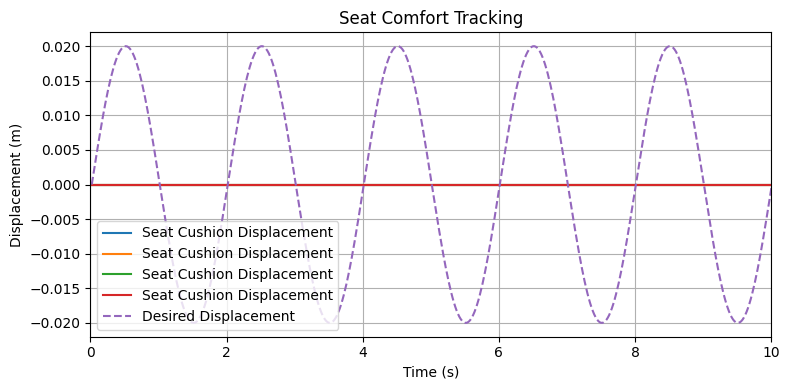

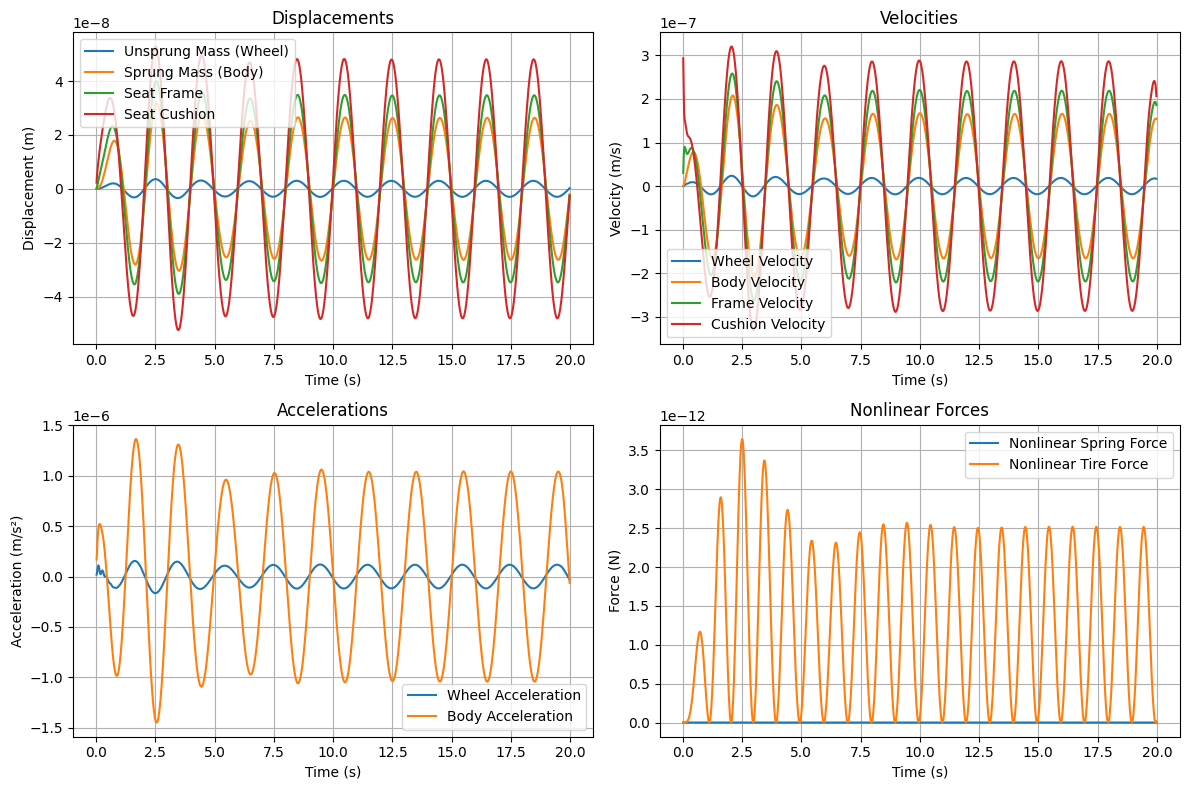

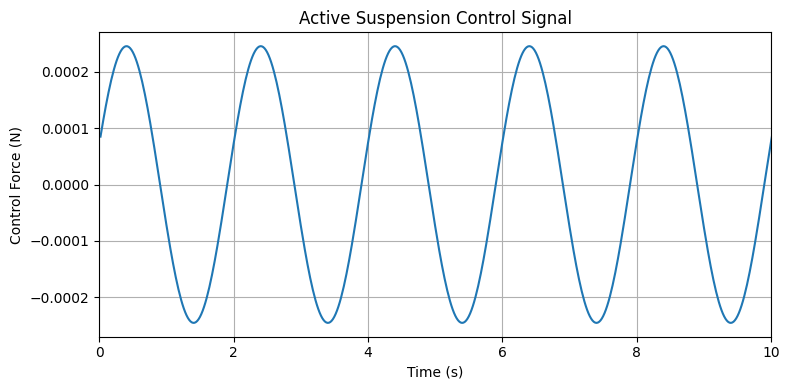

In [116]:
# Initialize the system
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
plant = CarSuspension(x0, T_f=10, dt=0.01)  

# Reference Input
Regulation = False
if Regulation:
    r = 0.02 * np.ones((len(plant.t_vec), 1), dtype=float)
else:
    r = 0.02 * np.sin(2 * np.pi * 1.0 * plant.t_vec)
    
# Controller
Q = np.diag([100, 10, 1, 1, 0.1, 0.1, 0.1, 0.1])
R = np.array([[0.01]])
mpc = NonlinearMPC(plant, N=20, M=10, Q=Q, R=R)

# Simulation
results = simulation(plant, r, mpc)


# Plot results
plots_output(plant, r[0:-1], results)
plots_state(plant, results)
plots_control(plant, results)

## Dataset Generation

In [117]:
def generate_control_signal(t_vec, u_min=-500, u_max=500, signal_type="road"):
    if signal_type == "road":
        frequency, amplitude = 1.0, 0.02
        return amplitude * np.sin(2 * np.pi * frequency * t_vec)
    elif signal_type == "step":
        u_signal = np.zeros_like(t_vec)
        u_signal[t_vec >= 2.0] = 0.02
        return u_signal
    else:
        raise ValueError("Invalid signal type. Use 'road' or 'step'.")

def simulate_experiment(plant, u_signal):
    plant.reset()
    state_hist, output_hist, control_hist = [], [], []
    
    for t in range(len(plant.t_vec)):
        u = u_signal[t]
        x_next, y = plant.step(u, False)
        plant.x, plant.y = x_next, y
        plant.t += plant.dt
        
        state_hist.append(x_next.flatten())
        output_hist.append(np.squeeze(y))
        control_hist.append(u)
    
    return state_hist, output_hist, control_hist

def normalize_data(data, data_min, data_max):
    return np.clip(2 * (data - data_min) / (data_max - data_min) - 1, -1, 1)

def generate_data(u_min=-500, u_max=500, timeframe=20, num_experiments=50, T_f=10, dt=0.01, signal_type="road"):
    x_data, y_data, u_data = [], [], []
    state_dim = 8
    
    x_min, x_max = np.array([-0.2, -0.3, -0.1, -0.1, -1.0, -1.0, -1.0, -1.0]), np.array([0.2, 0.3, 0.1, 0.1, 1.0, 1.0, 1.0, 1.0])
    
    for _ in range(num_experiments):
        x0 = np.random.uniform(low=x_min, high=x_max)
        plant = CarSuspension(x0, dt=dt, T_f=T_f)
        
        t_vec = plant.t_vec
        u_signal = generate_control_signal(t_vec, u_min, u_max, signal_type)
        
        x_hist, y_hist, u_hist = simulate_experiment(plant, u_signal)
        x_data.append(x_hist)
        y_data.append(y_hist)
        u_data.append(u_hist)
    
    u_data = [np.array(u) for u in u_data]
    normalized_states = [normalize_data(states, x_min, x_max) for states in x_data]
    normalized_outputs = [normalize_data(outputs, x_min[3], x_max[3]) for outputs in y_data]
    normalized_controls = [normalize_data(controls, u_min, u_max) for controls in u_data]
    
    model_inputs, model_targets, observer_inputs, observer_targets = [], [], [], []
    
    for states, outputs, controls in zip(normalized_states, normalized_outputs, normalized_controls):
        for t in range(len(states) - timeframe):
            model_inputs.append(np.column_stack([states[t:t+timeframe], controls[t:t+timeframe]]))
            model_targets.append(states[t+timeframe])
            observer_inputs.append(np.column_stack([controls[t:t+timeframe], outputs[t:t+timeframe]]))
            observer_targets.append(states[t+timeframe])
    
    model_inputs = np.array(model_inputs).reshape(-1, timeframe, state_dim + 1)
    model_targets = np.nan_to_num(np.array(model_targets).reshape(-1, 1, state_dim))
    observer_inputs = np.array(observer_inputs).reshape(-1, timeframe, 2)
    observer_targets = np.nan_to_num(np.array(observer_targets).reshape(-1, 1, state_dim))
    
    print("Data shapes:")
    print(f"Model inputs: {model_inputs.shape}")
    print(f"Model targets: {model_targets.shape}")
    print(f"Observer inputs: {observer_inputs.shape}")
    print(f"Observer targets: {observer_targets.shape}")
    
    return {
        "x_data": np.array(x_data),
        "u_data": np.array(u_data),
        "model_inputs": model_inputs,
        "model_targets": model_targets,
        "observer_inputs": observer_inputs,
        "observer_targets": observer_targets
    }


In [118]:
timeframe = 20
x_min = np.array([-0.2, -0.3, -0.1, -0.1, -1.0, -1.0, -1.0, -1.0])  # velocity and distance
x_max = np.array([0.2, 0.3, 0.1, 0.1, 1.0, 1.0, 1.0, 1.0])
u_min = -500  # control force
u_max = 500
results = generate_data(u_min, u_max, timeframe=timeframe, T_f=50, num_experiments=5)
x_data = results["x_data"]
u_data = results["u_data"]

C:\Users\ali\AppData\Local\Temp\ipykernel_27044\2340602067.py:50: RuntimeWarning: overflow encountered in scalar power
  - self.k_snl * (x_s - x_us)**3
C:\Users\ali\AppData\Local\Temp\ipykernel_27044\2340602067.py:56: RuntimeWarning: overflow encountered in scalar power
  - self.k_snl * (x_s - x_us)**3
C:\Users\ali\AppData\Local\Temp\ipykernel_27044\2340602067.py:48: RuntimeWarning: invalid value encountered in scalar subtract
  + self.c_s * (dx_s - dx_us)
C:\Users\ali\AppData\Local\Temp\ipykernel_27044\2340602067.py:49: RuntimeWarning: overflow encountered in scalar power
  + self.k_tnl * (x_us - 0)**2
C:\Users\ali\AppData\Local\Temp\ipykernel_27044\2340602067.py:55: RuntimeWarning: invalid value encountered in scalar subtract
  - self.c_s * (dx_s - dx_us)
C:\Users\ali\AppData\Local\Temp\ipykernel_27044\2340602067.py:47: RuntimeWarning: invalid value encountered in scalar subtract
  + self.k_s * (x_s - x_us)
C:\Users\ali\AppData\Local\Temp\ipykernel_27044\2340602067.py:50: RuntimeWarn

Data shapes:
Model inputs: (24900, 20, 9)
Model targets: (24900, 1, 8)
Observer inputs: (62250, 20, 2)
Observer targets: (24900, 1, 8)


In [119]:
print(f"Initial state: {plant.x}, Initial output: {plant.y}")


Initial state: [2.3541e-10, -2.01918e-09, -2.45731e-09, -2.53943e-09, 1.69856e-08, 1.54558e-07, 1.85889e-07, 2.06393e-07], Initial output: [2.3541e-10, -2.01918e-09, -2.45731e-09, -2.53943e-09]


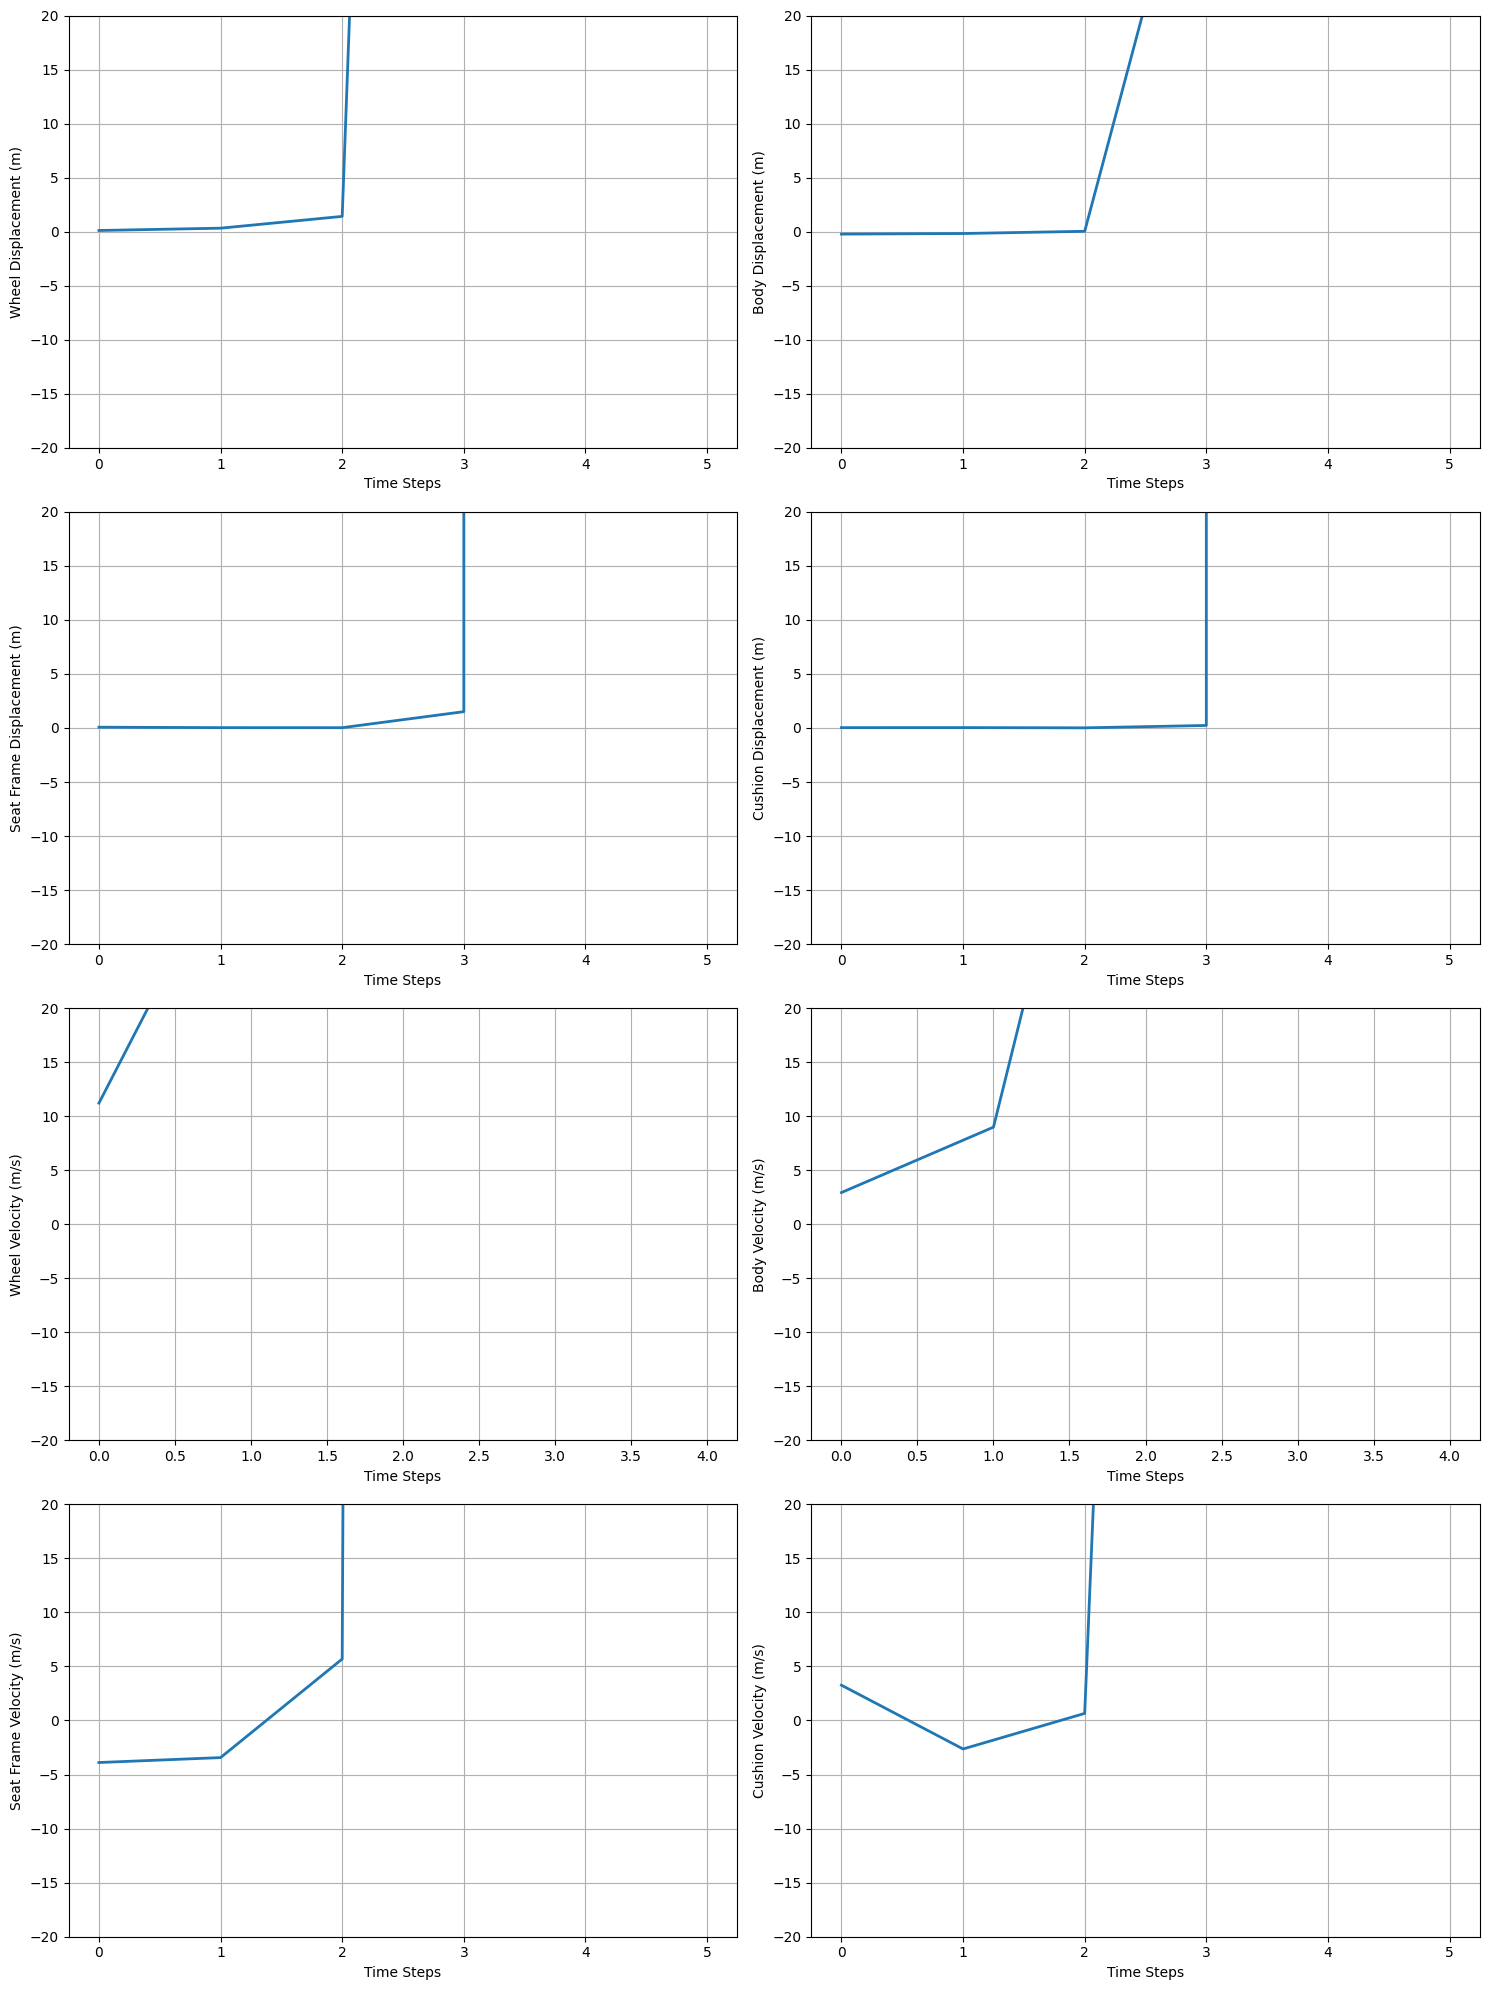

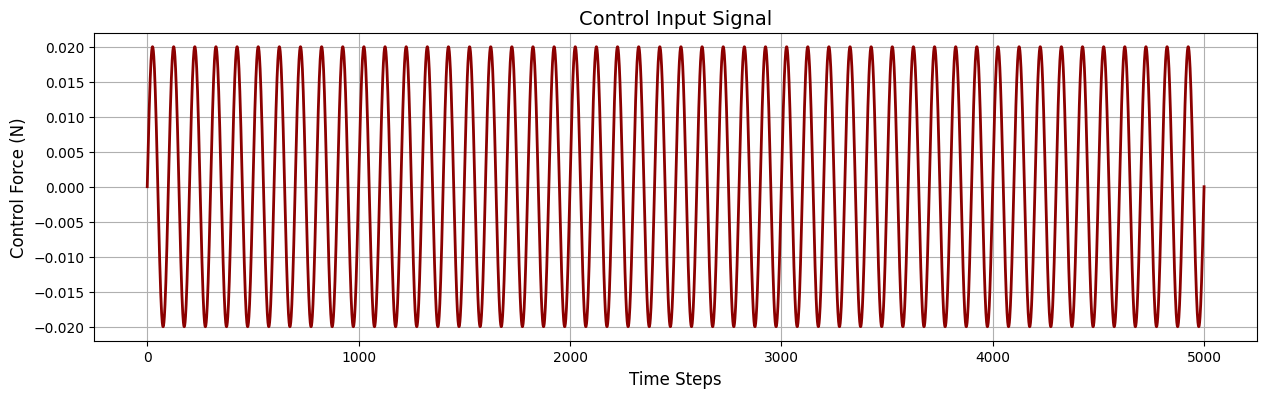

In [120]:
state_labels = [
    "Wheel Displacement (m)",
    "Body Displacement (m)",
    "Seat Frame Displacement (m)",
    "Cushion Displacement (m)",
    "Wheel Velocity (m/s)",
    "Body Velocity (m/s)",
    "Seat Frame Velocity (m/s)",
    "Cushion Velocity (m/s)"
]
plt.figure(figsize=(15, 20))

for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.plot(x_data[0, :, i], linewidth=2)
    plt.xlabel('Time Steps', fontsize=10)
    plt.ylabel(state_labels[i], fontsize=10)
    plt.ylim(-20, 20)
    plt.grid(True)
    
plt.tight_layout()

plt.figure(figsize=(15, 4))
plt.plot(u_data[0, :], linewidth=2, color='darkred')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Control Force (N)', fontsize=12)
plt.title('Control Input Signal', fontsize=14)
plt.grid(True)

plt.show()

## Define LSTM Networks

In [121]:
model_inputs = results["model_inputs"]
model_targets = results["model_targets"]
observer_inputs = results["observer_inputs"]
observer_targets = results["observer_targets"]

#handle invalid parameters
model_inputs = np.nan_to_num(model_inputs, nan=0.0, posinf=0.0, neginf=0.0)
model_targets = np.nan_to_num(model_targets, nan=0.0, posinf=0.0, neginf=0.0)
observer_inputs = np.nan_to_num(observer_inputs, nan=0.0, posinf=0.0, neginf=0.0)
observer_targets = np.nan_to_num(observer_targets, nan=0.0, posinf=0.0, neginf=0.0)

from sklearn.preprocessing import StandardScaler

# Initialize scalers for inputs and targets
scaler_inputs = StandardScaler()
scaler_targets = StandardScaler()
scaler_observer_inputs = StandardScaler()  # Separate scaler for observer_inputs

# Flatten inputs and targets for normalization
model_inputs_flat = model_inputs.reshape(-1, model_inputs.shape[-1])
model_targets_flat = model_targets.reshape(-1, model_targets.shape[-1])

# Normalize the data
model_inputs = scaler_inputs.fit_transform(model_inputs_flat).reshape(model_inputs.shape)
model_targets = scaler_targets.fit_transform(model_targets_flat).reshape(model_targets.shape)

# Flatten observer inputs and targets for normalization
observer_inputs_flat = observer_inputs.reshape(-1, observer_inputs.shape[-1])
observer_targets_flat = observer_targets.reshape(-1, observer_targets.shape[-1])

# Normalize the observer data
observer_inputs = scaler_observer_inputs.fit_transform(observer_inputs_flat).reshape(observer_inputs.shape)
observer_targets = scaler_targets.transform(observer_targets_flat).reshape(observer_targets.shape)

print("model_inputs shape:", model_inputs.shape)
print("model_targets shape:", model_targets.shape)
print("observer_inputs shape:", observer_inputs.shape)
print("observer_targets shape:", observer_targets.shape)

# Define the Model LSTM
model_lstm = Sequential([
    Input(shape=(model_inputs.shape[1], model_inputs.shape[2])),  # (timesteps, featutes)
    LSTM(100, return_sequences=False),  # LSTM layer activation='relu'
    #Dropout(0.1),
    #LSTM(32, return_sequences=False),
    Dense(16, activation='tanh'),  # Additional dense layer
    Dense(8) # Output: next state (2 values)
])

# Define the Observer LSTM
observer_lstm = Sequential([
    Input(shape=(observer_inputs.shape[1], observer_inputs.shape[2])),  
    LSTM(32, return_sequences=False),
    #Dropout(0.1), 
    Dense(16, activation='relu'),
    Dense(8)  # Output: next state (2 values)
])


# Train the Model LSTM
"""  Rules of Thumb:
Batch Size
Small batch sizes (8-32) → Better generalization, noisier gradients
Large batch sizes (64-256) → Faster training, but risks overfitting

Learning Rate
If the model is unstable (loss fluctuates too much) → Decrease (e.g., 0.0005 or 0.0001)
If learning is too slow → Increase (e.g., 0.005 or 0.01)
"""


model_lstm.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='mse') # loss=Huber()
observer_lstm.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='mse')
# hist_model = model_lstm.fit(model_inputs, model_targets, epochs=50, batch_size=64, validation_split=0.3)
#model_lstm.compile(loss='mse', optimizer='adam')
#observer_lstm.compile(loss='mse', optimizer='adam')
#from tensorflow.keras.optimizers import Adam
#model_lstm.compile(optimizer=Adam(learning_rate=5e-4), loss='mse')


model_lstm.compile(optimizer=Adam(learning_rate=0.0001, clipvalue=1.0), loss='mse')
observer_lstm.compile(optimizer=Adam(learning_rate=0.0001, clipvalue=1.0), loss='mse')


# Train the model
hist_model = model_lstm.fit(model_inputs,model_targets, batch_size=32,  epochs=20, validation_split=0.2)   
print("LSTM Model Trained!")
# Train the Observer LSTM
hist_observer = observer_lstm.fit(observer_inputs[:24900], observer_targets, batch_size=32,  epochs=20, validation_split=0.2)
print("LSTM Model Trained!")

model_inputs shape: (24900, 20, 9)
model_targets shape: (24900, 1, 8)
observer_inputs shape: (62250, 20, 2)
observer_targets shape: (24900, 1, 8)
Epoch 1/20


c:\Users\ali\anaconda3\envs\cvenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


623/623 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.4243 - val_loss: 3.3694
Epoch 2/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.4823 - val_loss: 3.3646
Epoch 3/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.3920 - val_loss: 3.3583
Epoch 4/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.4676 - val_loss: 3.3626
Epoch 5/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.4282 - val_loss: 3.3624
Epoch 6/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.3596 - val_loss: 3.3594
Epoch 7/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.4292 - val_loss: 3.3523
Epoch 8/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.3365 - val_loss: 3.3592
Epoch 9/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.3969 - val_loss: 3.3573
Epoch 10/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.4415 - val_loss: 3.3586
Epoch 11/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.4027 - val_loss: 3.3598
Epoch 12/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/ste

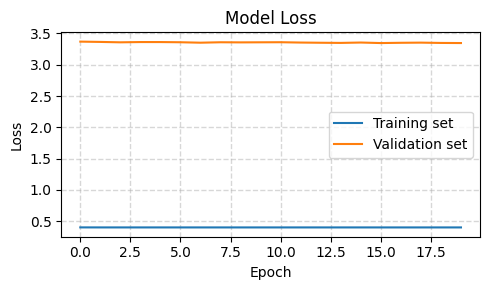

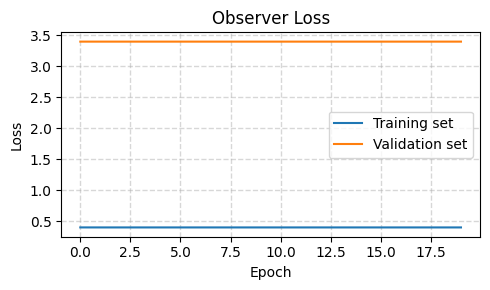

In [122]:
def render_training_history_loss(training_history,net):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    plt.figure(figsize=(5, 3))
    plt.title(net)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Validation set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.tight_layout()
    plt.show()
    
render_training_history_loss(hist_model, 'Model Loss')
render_training_history_loss(hist_observer, 'Observer Loss')

C:\Users\ali\AppData\Local\Temp\ipykernel_27044\2340602067.py:50: RuntimeWarning: overflow encountered in scalar power
  - self.k_snl * (x_s - x_us)**3
C:\Users\ali\AppData\Local\Temp\ipykernel_27044\2340602067.py:56: RuntimeWarning: overflow encountered in scalar power
  - self.k_snl * (x_s - x_us)**3
C:\Users\ali\AppData\Local\Temp\ipykernel_27044\2340602067.py:48: RuntimeWarning: invalid value encountered in scalar subtract
  + self.c_s * (dx_s - dx_us)
C:\Users\ali\AppData\Local\Temp\ipykernel_27044\2340602067.py:49: RuntimeWarning: overflow encountered in scalar power
  + self.k_tnl * (x_us - 0)**2
C:\Users\ali\AppData\Local\Temp\ipykernel_27044\2340602067.py:55: RuntimeWarning: invalid value encountered in scalar subtract
  - self.c_s * (dx_s - dx_us)
C:\Users\ali\AppData\Local\Temp\ipykernel_27044\2340602067.py:47: RuntimeWarning: invalid value encountered in scalar subtract
  + self.k_s * (x_s - x_us)
C:\Users\ali\AppData\Local\Temp\ipykernel_27044\2340602067.py:50: RuntimeWarn

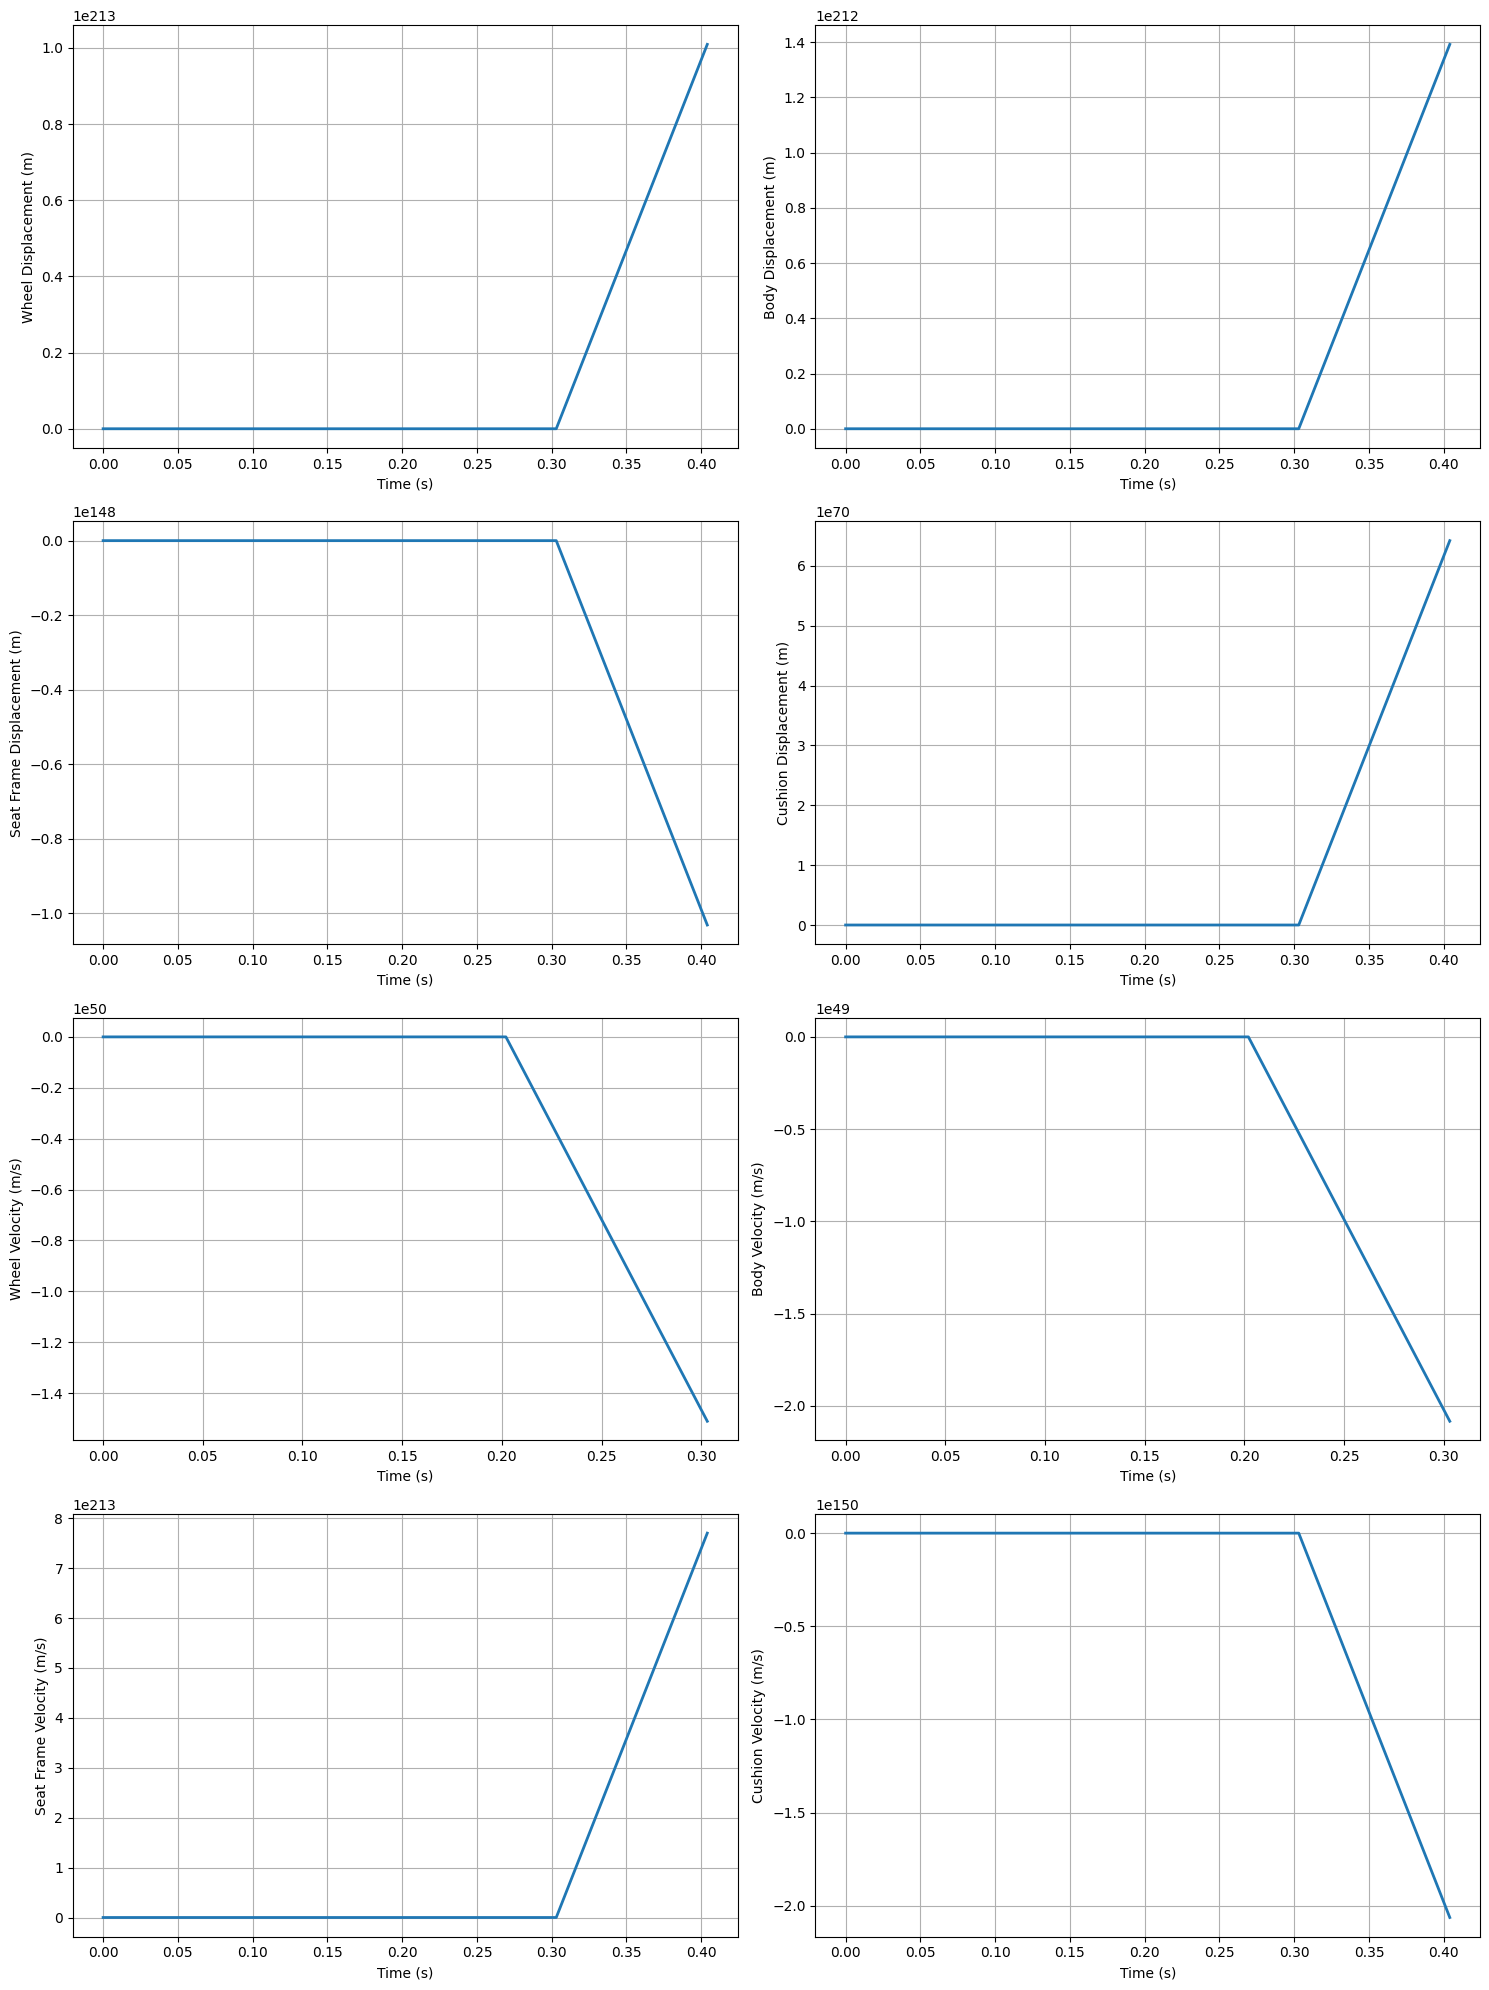

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Initial conditions
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])  # [x_us, x_s, x_f, x_c, dx_us, dx_s, dx_f, dx_c]

# Initialize the system
plant = CarSuspension(x0, dt=0.1, T_f=10)

# Control signal (sinusoidal)
u_signal = 500 * np.sin(2 * np.pi * 1.0 * plant.t_vec)  # Control force (N)

# System simulation
real_states = []
real_outputs = []
plant.reset()

for u in u_signal:
    x, y = plant.step(u, False)
    plant.x, plant.y = x, y
    real_states.append(x.flatten())  # States
    real_outputs.append(np.squeeze(y))  # Output (seat cushion displacement)

real_states = np.array(real_states)
real_outputs = np.array(real_outputs)

# State labels
state_labels = [
    "Wheel Displacement (m)",
    "Body Displacement (m)",
    "Seat Frame Displacement (m)",
    "Cushion Displacement (m)",
    "Wheel Velocity (m/s)",
    "Body Velocity (m/s)",
    "Seat Frame Velocity (m/s)",
    "Cushion Velocity (m/s)"
]

# Plot states
plt.figure(figsize=(15, 20))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.plot(plant.t_vec, real_states[:, i], linewidth=2)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel(state_labels[i], fontsize=10)
    plt.grid(True)
plt.tight_layout()

plt.show()
